# Project 3
## Summarization of GitHub issues
### Gianluca Rea m.278722

In [1]:
from attention_keras import *

In [2]:
#pip install lxml

### Imports

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras import backend as K 
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gianlucarea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Loading data
df = pd.read_csv('../github_issues.csv',nrows=7000)
df.drop(['issue_url'], axis=1, inplace=True)

df.head(3)

,issue_title,body
0,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...
1,hcl accessibility a11yblocking a11ymas mas4.2.10 hcl-makecode win10-edge -title screen reader-help-javascript-call a function narrator focus does not moving to expand side a documentation button a...,user experience: user who depends on screen reader will get confused if narrator focus does not retain on expand side a documentation button after pressing enter on collapse side a documentation b...
2,issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issue 1256: issue 1253: issue 1252: issue 1250: issue 1247: issue 1246: issue 1243: issue 1242: issue 1239: issue 1237: issue 1236: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265</a>


In [5]:
df.shape

(7000, 2)

### Preprocessing

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
stop_words = set(nltk.corpus.stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    newString = re.sub('issue',"",newString)
    newString = re.sub('issu',"",newString)

    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [8]:
#call the function
cleaned_body = []
for t in df['body']:
    cleaned_body.append(text_cleaner(t,0)) 

In [9]:
#call the function
cleaned_title = []
for t in df['issue_title']:
    cleaned_title.append(text_cleaner(t,1))

In [10]:
print(cleaned_title[1])
print('-' * 75)
print(cleaned_body[1])

hcl accessibility yblocking ymas mas hcl makecode win edge title screen reader help javascript call function narrator focus does not moving to expand side documentation button after pressing enter on collapse side documentation button
---------------------------------------------------------------------------
user experience user depends screen reader get confused narrator focus retain expand side documentation button pressing enter collapse side documentation button test environment os rs version os build platform edge screen reader narrator repro steps navigate https makecode microbit org acc navigate micro bit section element select code control given navigate help control lying header section page select navigate javascript control select navigate various controls lying pane opened navigate pane opened select link listed verify narrator focus moving expand side documentation button pressing enter collapse side documentation button actual result narrator focus retain expand side doc

In [11]:
df.head()

,issue_title,body
0,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...,can't load the addon. issue to: https://github.com/zhangyuanwei/node-images/issues error: /lib64/libc.so.6: version glibc_2.14' not found required by /usr/local/app/taf/fileserver.fileserver/bin/s...
1,hcl accessibility a11yblocking a11ymas mas4.2.10 hcl-makecode win10-edge -title screen reader-help-javascript-call a function narrator focus does not moving to expand side a documentation button a...,user experience: user who depends on screen reader will get confused if narrator focus does not retain on expand side a documentation button after pressing enter on collapse side a documentation b...
2,issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issue 1256: issue 1253: issue 1252: issue 1250: issue 1247: issue 1246: issue 1243: issue 1242: issue 1239: issue 1237: issue 1236: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1265</a>
3,issue 1266: issue 1263: issue 1262: issue 1259: issue 1258: issue 1255: issue 1254: issue 1251: issue 1249: issue 1248: issue 1245: issue 1244: issue 1241: issue 1240: issue 1238: issue 1235: issu...,"gitlo = github x trello\n---\nthis board is now linked with https://github.com/matisiekpl/czekolada , any update on the issue tracker will be sync to this board. -------\nvia trello, you can: --- ..."
4,issue 1288: issue 1285: issue 1284: issue 1281: issue 1280: issue 1277: issue 1276: issue 1273: issue 1272: issue 1269: issue 1268: issue 1265: issue 1264: issue 1261: issue 1260: issue 1257: issu...,┆attachments: <a href= https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1288 >https:& x2f;& x2f;github.com& x2f;matisiekpl& x2f;czekolada& x2f;issues& x2f;1288</a>


In [12]:
data = pd.DataFrame()
data['cleaned_title']=cleaned_title
data['cleaned_body']=cleaned_body

In [13]:
## Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

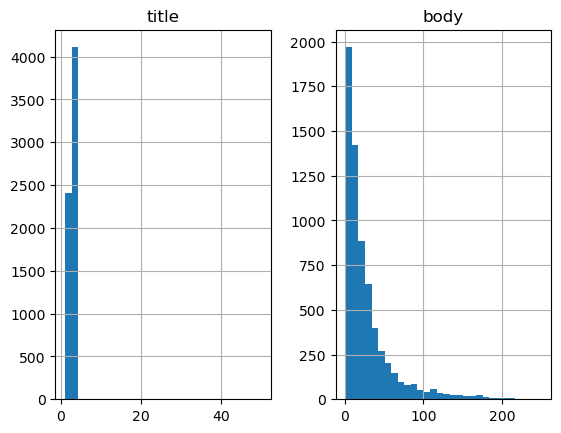

In [14]:
# Understanding the distribution of the sequences
body_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_body']:
      body_word_count.append(len(i.split()))

for i in data['cleaned_title']:
      title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'title':title_word_count, 'body':body_word_count})

length_df.hist(bins = 30)
plt.show()

In [15]:
cnt=0
for i in data['cleaned_title']:
    if(len(i.split())<=8):
        cnt=cnt+1
print("Title % < than 8 words")
print(cnt/len(data['cleaned_title']))
print('-' * 80)
cnt=0
print("Body % < than 120 words")
for i in data['cleaned_body']:
    if(len(i.split())<= 120):
        cnt=cnt+1
print(cnt/len(data['cleaned_body']))

Title % < than 8 words
0.9948147018453561
--------------------------------------------------------------------------------
Body % < than 120 words
0.9691932286106452


In [16]:
max_title_len=8
max_body_len=120

In [17]:
#Let us select the title and body whose length falls below or equal to max_title_len and max_body_len

cleaned_title =np.array(data['cleaned_title'])
cleaned_body=np.array(data['cleaned_body'])

short_title=[]
short_body=[]

for i in range(len(cleaned_body)):
    if(len(cleaned_title[i].split())<=max_title_len and len(cleaned_body[i].split())<=max_body_len):
        short_title.append(cleaned_title[i])
        short_body.append(cleaned_body[i])
        
df=pd.DataFrame({'title':short_title,'body':short_body})
df.head(1800)

,title,body
0,invalid,https github com softuni programming basics book java bg blob master chapter simple calculations md judge https github com softuni programming basics book java bg blob master assets chapter images...
1,rk,heroku api
2,all,app name bundle id uk co channel ios od itunes id itunes url https itunes apple com gb app id mt uo app version seller channel developer channel supported devices ipad wifi ipad iphone ipadthirdge...
3,api,hi wonder contributing api something might interested starting anything wanted feedback
4,fix,return users created post
...,...,...
1795,is sweet,loaded cleared cache data pixel icons awesome
1796,vs,returns complexinfinity returns infinity probably complexinfinity
1797,next steps,follow user parse tag password reset macro accomadation
1798,add me,adding map hi everyone track addition map found longitude latitude


In [18]:
# Adding special tokens sostok and eostok as START and END tokens of title
df['title'] = df['title'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['body']),np.array(df['title']),test_size=0.1,random_state=0,shuffle=True) 

## Tokenizing 

### Body Tokenizer

In [20]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [21]:
thresh=3

cnt=0 ### Number of rare words -> words appearing less than the thresh
tot_cnt=0 ### Vocabulary size
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 69.2326794139558
Total Coverage of rare words: 12.608193671267731


In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_body_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_body_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [23]:
x_voc

6196

### Title Tokenizer

In [24]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.52282410225197
Total Coverage of rare words: 16.99166475491321


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_title_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(5692, 5692)

In [28]:
### Delete row with only Start and End Tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Model building

In [30]:
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_body_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Metal device set to: Apple M1


2023-01-12 11:32:02.761157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-12 11:32:02.761408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 120, 100)     619600      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 120, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [33]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=7,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/7


2023-01-12 11:32:03.363341: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-12 11:32:05.834410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 2.2366  

2023-01-12 12:33:26.482266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 3694s 90s/step - loss: 2.2366 - val_loss: 1.7701
Epoch 2/7
41/41 [==============================] - 3847s 94s/step - loss: 1.7534 - val_loss: 1.6090
Epoch 3/7
41/41 [==============================] - 3681s 90s/step - loss: 1.6552 - val_loss: 1.5470
Epoch 4/7
41/41 [==============================] - 3832s 93s/step - loss: 1.6000 - val_loss: 1.5226
Epoch 5/7
41/41 [==============================] - 3824s 93s/step - loss: 1.5686 - val_loss: 1.5125
Epoch 6/7
41/41 [==============================] - 3769s 92s/step - loss: 1.5260 - val_loss: 1.5280
Epoch 7/7
41/41 [==============================] - 3861s 94s/step - loss: 1.4953 - val_loss: 1.5498
Epoch 7: early stopping


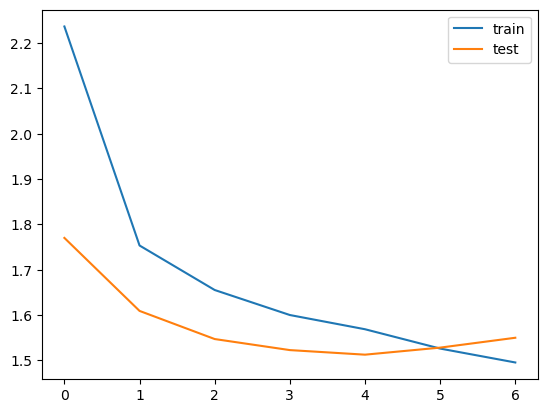

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_body_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [60]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_body_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [65]:
i = 120    
print("Body:",seq2text(x_tr[i]))
print("Original title:",seq2summary(y_tr[i]))
print("Predicted title:",decode_sequence(x_tr[i].reshape(1,max_body_len)))
print("\n")

Body: incomplete list needed additional read content log files send last integrity check result send installed extensions 
Original title: add new 
1/1 [==============================] - 0s 16ms/step
Predicted title:  add


